# Make sentence evaluation sample dataset

We want to sanity check the accuracy of the [ArgumenText](https://api.argumentsearch.com/en/doc) API. One way to do this is spot checks on the results, and using those spot checks to estimate precision and recall.

**Precision**  
Also known as "positive predictive value."  
Out of all of the retrieved instances, how many of them are correctly retrieved/classified?  
For argument mining, this is evaluated by looking at all of the sentences classified as an argument, and verifying how many of them actually contain an argument.

**Recall / Sensitivity**  
Also known as the true positive rate.  
What is the proportion of classified positives given all of the labeled positives. The extend of how often actual positives are not overlooked.
High sensitivity means that a true positive is rarely overlooked. This often comes at a loss of specificity.


**Specificity**  
Also known as the true negative rate.  
What is the proportion of classified negatives given all of the labeled negatives.
High specificity means that a true negative is rarely overlooked.

In [1]:
# reload local package definitions for each cell
%load_ext autoreload
%autoreload 2

In [67]:
import os
import time

from dotenv import find_dotenv, load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from arg_mine import DATA_DIR, FIGURES_DIR
from arg_mine.data import loaders, labelers
from arg_mine.api import classify, auth, session, errors
from arg_mine.visualization.plot_utils import make_confusion_matrix
from arg_mine import utils

SEED = 12345

sns.set_style("whitegrid")

In [3]:
# load the 2020 context snippet, for access later
csv_datapath = os.path.join(DATA_DIR, "raw", "2020-climate-change-narrative")
csv_filepath = os.path.join(csv_datapath, "WebNewsEnglishSnippets.2020.csv")

url_df = loaders.get_gdelt_df(csv_filepath)

INFO:2020-07-15 22:34:58,603:arg_mine.data.loaders: reading data from: /opt/workspace/data/raw/2020-climate-change-narrative/WebNewsEnglishSnippets.2020.csv


In [4]:
start_time = time.time()
data_processed_project = "gdelt-climate-change-docs"
base_path = os.path.join(DATA_DIR, "processed", data_processed_project)
docs_df = loaders.load_processed_csv("gdelt_2020_docs_docs0-999.csv", data_processed_project)

print("data load took {:0.1f} s".format(time.time() - start_time))

sentences_full_df = loaders.load_processed_csv("gdelt_2020_sentences_docs0-999.csv", data_processed_project, drop_nan_cols='sentence_original')

INFO:2020-07-15 22:35:00,076:arg_mine.data.loaders: reading data from: /opt/workspace/data/processed/gdelt-climate-change-docs/gdelt_2020_docs_docs0-999.csv
INFO:2020-07-15 22:35:00,094:arg_mine.data.loaders: reading data from: /opt/workspace/data/processed/gdelt-climate-change-docs/gdelt_2020_sentences_docs0-999.csv


data load took 0.0 s


In [5]:
# downsample the docs to something manageable
docs_sampled = docs_df.sample(n=30, random_state=SEED)
doc_ids = docs_sampled.doc_id.values

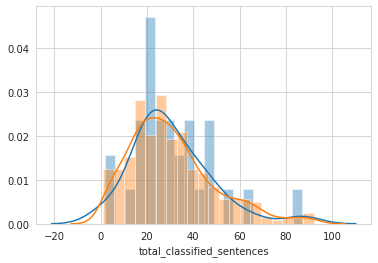

In [6]:
# how many sentences per doc in our sample? is this representative of the whole population?
fig, ax = plt.subplots()
n_bin = 20
sns.distplot(docs_sampled['total_classified_sentences'], bins=n_bin, kde=True, rug=False, ax=ax)
sns.distplot(docs_df.loc[docs_df['total_classified_sentences']<100, 'total_classified_sentences'], bins=n_bin, kde=True, rug=False, ax=ax)

In [7]:
# quick sanity check if our sample is representative of the whole
from scipy.stats import ks_2samp
ks_2samp(docs_sampled['total_classified_sentences'], docs_df.loc[docs_df['total_classified_sentences']<100, 'total_classified_sentences'])

# it's not :(

Ks_2sampResult(statistic=0.12655367231638417, pvalue=0.6983380593399297)

In [8]:
# filter the sentences to only our subsampled dataset
sentences_df = sentences_full_df[sentences_full_df.doc_id.isin(doc_ids)].copy()
# add the context labels
sentences_df = labelers.label_gdelt_context(url_df, docs_sampled, sentences_df)

no argument    677
argument       244
Name: argument_label, dtype: int64

Total # of sentences: 921


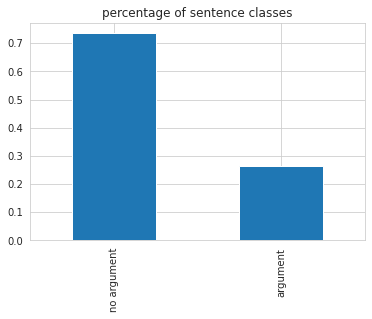

In [9]:
arg_label_counts = sentences_df.argument_label.value_counts()
print(arg_label_counts)
print("\nTotal # of sentences: {}".format( sentences_df.shape[0]))
(arg_label_counts / sentences_df.shape[0]).plot(kind="bar")
_ = plt.title("percentage of sentence classes")

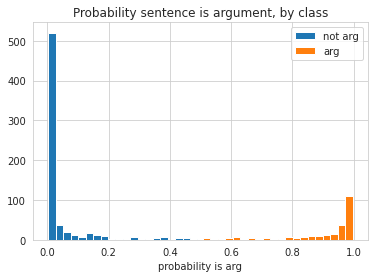

In [10]:
n_bins = 20
fig, ax = plt.subplots()
_ = plt.hist(
    sentences_df.loc[sentences_df['argument_label'] == classify.ArgumentLabel.NO_ARGUMENT, 'argument_confidence'],
    bins=n_bins, label='not arg')
_ = plt.hist(
    sentences_df.loc[sentences_df['argument_label'] == classify.ArgumentLabel.ARGUMENT, 'argument_confidence'],
    bins=n_bins, label='arg')
plt.xlabel("probability is arg")
plt.title("Probability sentence is argument, by class")
_ = plt.legend()

# Downsample the sentences
We have 921 sentences, with roughly a quarter of them classified as containing an argument relating to the topic `climate change`.

We can downsample this dataset again to make it more manageable for a human to look through.

In [11]:
# downsample to something manageable
N_SENTENCES = 100

keep_columns = [
    "doc_id", "topic", "sentence_id", "argument_confidence", "argument_label", "sentence_preprocessed"
]

sentence_sample_df = sentences_df.sample(n=N_SENTENCES, random_state=SEED)[keep_columns]

# some sentences have newlines in them. Let's remove those.
sentence_sample_df['sentence_preprocessed'] = sentence_sample_df['sentence_preprocessed'].str.replace("\n", " ")

In [12]:
sentence_sample_df.argument_label.value_counts()

no argument    84
argument       16
Name: argument_label, dtype: int64

In [13]:
# write out the sampled sentences

review_filename = "argtext_sentences_manual_review.csv"
review_filename = os.path.join(DATA_DIR, "interim", review_filename)
sentence_sample_df.reset_index().to_csv(review_filename, index_label="row_number")

In [14]:
sentence_sample_df

,doc_id,topic,sentence_id,argument_confidence,argument_label,sentence_preprocessed
3616,55b52545354300be300fdcbe8350661f,climate change,aa9cc2b5dabdff113d4d8a01932b227a,0.714489,argument,"Akanksha Khatri, head of WEF’s nature and biod..."
28265,12cdddec7f658c7085a3b34aacf14cae,climate change,6942b531afd974edda93932dd5126ea5,0.004897,no argument,"“All you have seen the upside down flag,” Ward..."
28243,12cdddec7f658c7085a3b34aacf14cae,climate change,9e26ac043712fec35b21469762dd824a,0.005150,no argument,Hundreds of opponents to the Thirty Meter Tele...
12176,0315e2ee06ea460dcd4b0e790dd23623,climate change,04ef2f4623e27e480af203a24b5eaf3b,0.004153,no argument,You can find out more about our policy and you...
27971,4d84047d2d8929a8e5db3c2ba07c6b71,climate change,d6d77c1b9f8e0d950f79b1f98f5a0ce2,0.009404,no argument,"""But look, this question about whether or not ..."
...,...,...,...,...,...,...
5991,6e018df8352302b5a7f5077b60781e05,climate change,3b9e15c3e8869be35ab4e070101e54c2,0.004817,no argument,Tue 21 Jan 2020 04:38 PM
17272,af63ba495706eac74021b32ee6abe612,climate change,24d277268db19e92015c98416d5e2675,0.004218,no argument,This website and associated newspapers adhere ...
12582,5af7d4c14e33e48e81a7a6bf1501d247,climate change,b22e3ad514bf84999d2ba110bc8e66b5,0.949133,argument,One thing that we also know is that we're goin...
4163,3d1cdb2952022d737697520a28de09bb,climate change,80a2a156d300fe2dbf3151be8bd0268a,0.006120,no argument,Be boastful in regards to teaching others how ...


## Write out more sentences for evaluation
Sampling 100 sentences isnt much, let's make a bigger dataset.

To make this a bit easier and make the classes balanced, let's select N/2 positive and N/2 negative examples

In [92]:
sentences_full_df.columns

Index(['url', 'doc_id', 'topic', 'sentence_id', 'argument_confidence',
       'argument_label', 'sentence_original', 'sentence_preprocessed',
       'sort_confidence', 'stance_confidence', 'stance_label'],
      dtype='object')

In [ ]:
sentences_df.loc[sentences_df['argument_label'] == classify.ArgumentLabel.NO_ARGUMENT]

In [100]:
# downsample to something manageable
N_SENTENCES = 1000
class_sample_len = N_SENTENCES // 2

keep_columns = [
    "doc_id", "topic", "sentence_id", "argument_confidence", "argument_label", "sentence_preprocessed"
]

sentence_sample_df_neg = sentences_full_df.loc[sentences_full_df['argument_label'] == classify.ArgumentLabel.NO_ARGUMENT].sample(n=class_sample_len, random_state=SEED)[keep_columns]
sentence_sample_df_pos = sentences_full_df.loc[sentences_full_df['argument_label'] == classify.ArgumentLabel.ARGUMENT].sample(n=class_sample_len, random_state=SEED)[keep_columns]
sentence_sample_df = pd.concat([sentence_sample_df_neg, sentence_sample_df_pos], axis=0)

# some sentences have newlines in them. Let's remove those.
sentence_sample_df['sentence_preprocessed'] = sentence_sample_df['sentence_preprocessed'].str.replace("\n", " ")

# shuffle, so we arent looking at the same class in a row.
sentence_sample_df = sentence_sample_df.sample(frac=1, random_state=SEED)

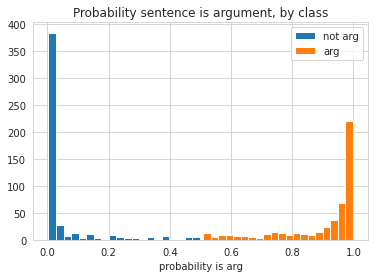

In [102]:
n_bins = 20
fig, ax = plt.subplots()
_ = plt.hist(
    sentence_sample_df.loc[sentence_sample_df['argument_label'] == classify.ArgumentLabel.NO_ARGUMENT, 'argument_confidence'],
    bins=n_bins, label='not arg')
_ = plt.hist(
    sentence_sample_df.loc[sentence_sample_df['argument_label'] == classify.ArgumentLabel.ARGUMENT, 'argument_confidence'],
    bins=n_bins, label='arg')
plt.xlabel("probability is arg")
plt.title("Probability sentence is argument, by class")
_ = plt.legend()

In [98]:
sentence_sample_df.argument_label.value_counts()

no argument    500
argument       500
Name: argument_label, dtype: int64

In [103]:
# write out the sampled sentences

review_filename = "argtext_sentences_manual_review_1k.csv"
review_filename = os.path.join(DATA_DIR, "interim", review_filename)
sentence_sample_df.reset_index().to_csv(review_filename, index_label="row_number")

# Evaluate the manual labels to the machine labels
Let's look at accuracy, precision, and recall for the model.

precision: how many true positives are there out of all predicted positives?  
recall: how many predicted positives are there out of all true positives?

In [68]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

In [65]:
review_output_filename = "argtext_gdelt_sentence_manual_review_100-reviewed.csv"
review_output_filename = os.path.join(DATA_DIR, "interim", review_output_filename)

reviewed_sent_df = pd.read_csv(review_output_filename)
reviewed_sent_df.dropna(inplace=True)

y_model = reviewed_sent_df.is_arg.astype(int)
y_model_conf = reviewed_sent_df.argument_confidence
y_label = reviewed_sent_df.binarized.astype(int)


### Confusion matrix

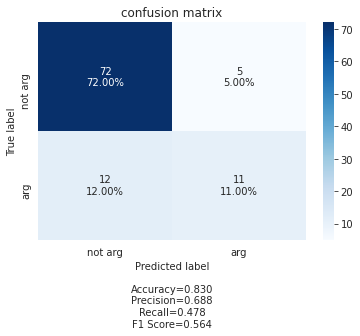

In [63]:
cf_matrix = confusion_matrix(y_label, y_model)

fig = make_confusion_matrix(cf_matrix, categories=["not arg", "arg"], title="confusion matrix")
plt.savefig(os.path.join(FIGURES_DIR, "argtext_validation_100sentence_cm.png"))

### ROC curve
Typically, we want to have as low of a FPR and as high of a TPR as possible, effectively pushing the curve up and to the left. The unity line denotes random chance for this binomial problem.

In [90]:
fpr, tpr, thresholds = roc_curve(y_label, y_model_conf)
roc_auc = auc(fpr, tpr)

# select the point that is used as the default threshold = 0.5
selected_thresh = 0.5
thresh_ix = np.argmin(np.abs(thresholds-selected_thresh))
thresh_fpr = fpr[thresh_ix]
thresh_tpr = tpr[thresh_ix]

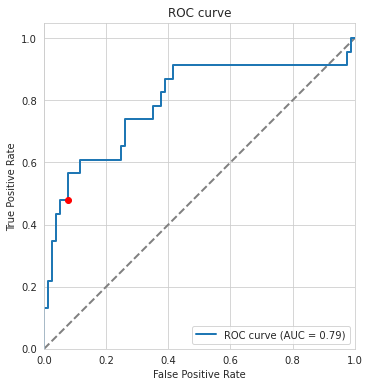

In [89]:
fig, ax = plt.subplots(figsize=(6,6))
lw = 2
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.plot(
    fpr, tpr, 
    lw=lw, label='ROC curve (AUC = {:0.2f})'.format(roc_auc))
plt.plot(thresh_fpr, thresh_tpr, 'ro')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
ax.set_aspect('equal', 'box')

### Precision Recall

In [32]:
precision, recall, thresholds = precision_recall_curve(y_label, y_model_conf)

In [51]:
thresh_ix = np.argmin(np.abs(thresholds-selected_thresh))
thresh_recall = recall[thresh_ix]
thresh_precision = precision[thresh_ix]
print("Default threshold ({}) => recall={:0.2f}, precision={:0.2f}".format(selected_thresh, thresh_recall, thresh_precision))

Default threshold (0.5) => recall=0.48, precision=0.69


Default threshold (0.5) => recall=0.478, precision=0.688


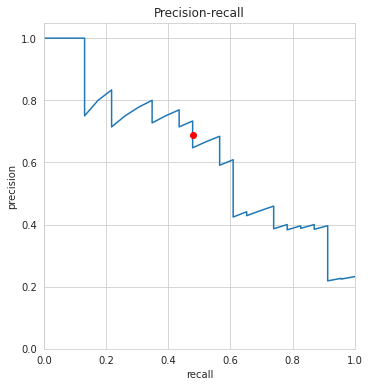

In [77]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(recall, precision, label="precision-recall curve")
plt.plot(thresh_recall, thresh_precision, 'ro')
plt.xlim((0, 1.0))
plt.ylim((0, 1.05))
ax.set_aspect('equal', 'box')
plt.xlabel("recall")
plt.ylabel("precision")
_ = plt.title("Precision-recall")
print("Default threshold ({}) => recall={:0.3f}, precision={:0.3f}".format(selected_thresh, thresh_recall, thresh_precision))